# workflow 
1. import necessary library in one single cell
2. ingest data
3. clean data
4. choose y value
5. set the datetime as index
6. resample : up or down if necessary
7. plot observed timeseries
8. determine validation set
9. decompose the observed series
10. analyze the decomposed ts
11. if necessary, make the data stationary which  satisfy the assumption:
- data has same mean (no trend)
- data has the same variance (no heteroscedasticity)
- data should be in similiar covariance (somekind of wavelength)

12. first approach : use differencing or timeseries(t) - lag(k)
13. remove the heteroscedasticity using log transform
14. assume the data is now stattionary, one's can :
15. use ACF to determine MA order (q)
16. use PACF to determine AR order (p)
17. model the data using arima with known components
18. evaluate the model prediction on validation set
19. move forward to sarima model
18. using arima residuals to get sarima components using acf pacf
19. model sarima with known properties
20. evaluate the sarima model
21. assume the model us good, forecast to the out of observed data

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing,SimpleExpSmoothing,Holt,HoltWintersResults
from scipy.stats import normaltest,boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.api import ARIMA,SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [ ]:
df_train = pd.read_csv("/content/Train_SU63ISt.csv")
df_test = pd.read_csv("/content/Test_0qrQsBZ.csv")

In [ ]:
print("train shape",df_train.shape)
print("test shape",df_test.shape)

train shape (18288, 3)
test shape (5112, 2)


In [ ]:
df_train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [ ]:
df_train.isnull().sum()

ID          0
Datetime    0
Count       0
dtype: int64

In [ ]:
df_train[df_train.duplicated()]

,ID,Datetime,Count


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        18288 non-null  int64 
 1   Datetime  18288 non-null  object
 2   Count     18288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.8+ KB


In [ ]:
df_train['Datetime'] = pd.to_datetime(df_train['Datetime'])
df_train.index = df_train['Datetime']

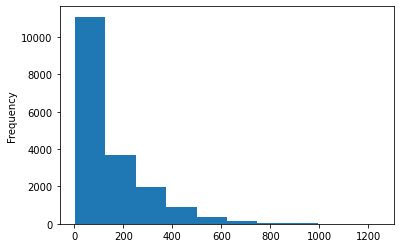

In [ ]:
df_train.Count.plot(kind='hist')

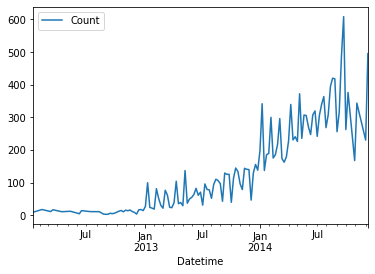

In [ ]:
ts  = df_train[['Count']].resample("W").mean().interpolate()
ts.plot()

In [ ]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 153 entries, 2012-01-15 to 2014-12-14
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Count   153 non-null    float64
dtypes: float64(1)
memory usage: 2.4 KB


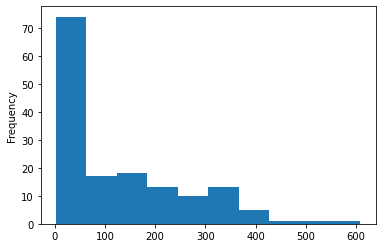

In [ ]:
ts.Count.plot(kind='hist')

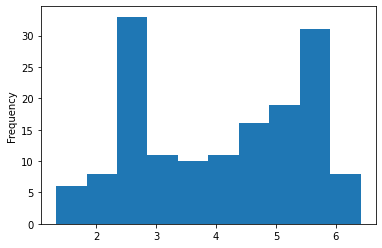

In [ ]:
#transformation if necessary
log1p_count = np.log1p(ts.Count)
boxcx_count = boxcox(np.asarray(ts.Count),lmbda=0.5)
log1p_count.plot(kind='hist')
#plt.hist(boxcx_count)

In [ ]:
#normal distribution test
tstat_b,pval_b = normaltest(np.asarray(ts.Count))
tstat_log,pval_log = normaltest(np.asarray(log1p_count))
tstat_boxcx,pval_boxcx = normaltest(np.asarray(boxcx_count))

print(f"before any transform the pval of normal: {pval_b}")
print(f"log1p transform the pval of normal: {pval_log}")
print(f"boxcx transform the pval of normal: {pval_boxcx}")
#apply log1p to create new features

before any transform the pval of normal: 2.328878047702437e-06
log1p transform the pval of normal: 6.359193235960362e-35
boxcx transform the pval of normal: 6.851508985540486e-09


In [ ]:
ts['log1p_Count'] = np.log1p(ts.Count)

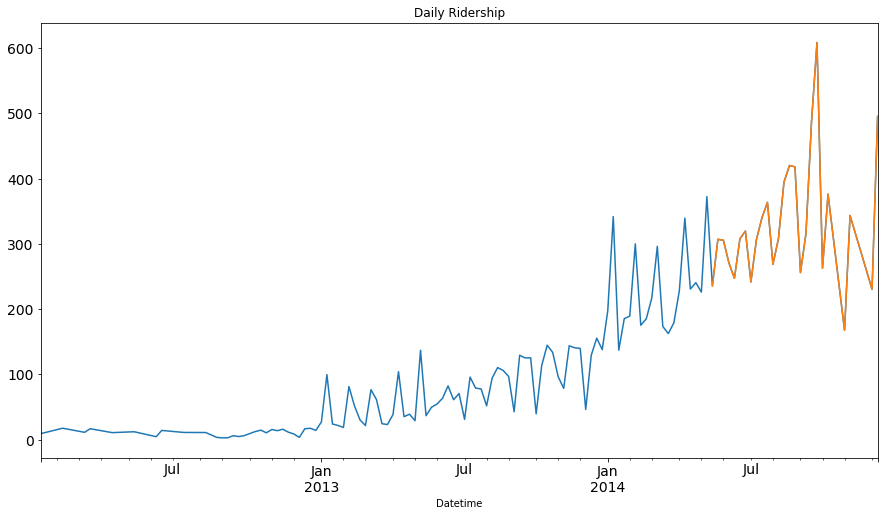

In [ ]:
#splitting into val subset
train_size = int(len(ts)*0.8)
val_subset = ts[train_size:]
val_start = "2014-05-18"
val_end = "2014-12-14"
#plotting
ts.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
val_subset.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)

the pvalue of timeseries 
 (1.2012187405483696, 0.9959942926911094, 12, 140, {'1%': -3.4779446621720114, '5%': -2.8824156122448983, '10%': -2.577901887755102}, 1473.7866784113105) 
 the series is not stationary


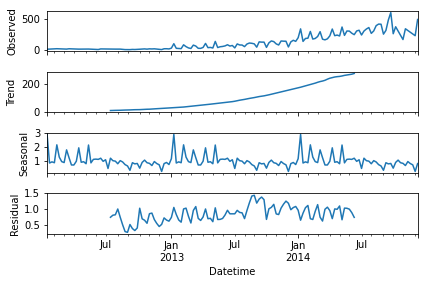

In [ ]:
#stationary test
stationary_test = adfuller(ts.Count)
print(f"the pvalue of timeseries \n {stationary_test} \n the series is not stationary")
decompose = seasonal_decompose(ts['Count'],model='multiplicative')
figure = decompose.plot() #assign to figure to avoid duplication

# Naive forecasting 1
using yt+1 = yt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


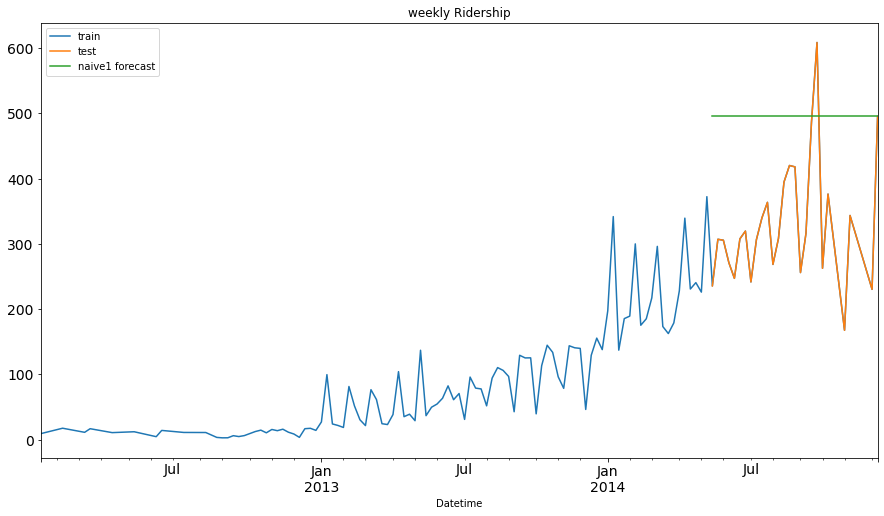

In [ ]:
val_subset['naive1'] = ts['Count'][-1]
ts.Count.plot(figsize=(15,8), title= 'weekly Ridership', fontsize=14,label='train')
val_subset.Count.plot(figsize=(15,8), title= 'weekly Ridership', fontsize=14,label='test')
val_subset.naive1.plot(figsize=(15,8), title= 'weekly Ridership', fontsize=14,label='naive1 forecast')
plt.legend()
plt.show()

In [ ]:

naive1_RMSE = np.sqrt(MSE(val_subset['Count'],val_subset['naive1']))
print(f"naive1 RMSE: {naive1_RMSE}")

naive1 RMSE: 194.37084487642338


# naive forecasting 2
using lag-1 or yt = yt-1

In [ ]:
ts['lag1_Count'] = ts['Count'].shift(1)

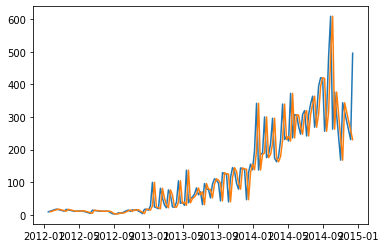

In [ ]:
plt.plot(ts.Count)
plt.plot(ts.lag1_Count)

# Simple exponential smoothing or single exponential smoothing

In [ ]:
ses_model = SimpleExpSmoothing(ts['Count']).fit(smoothing_level=0.4,optimized=True)
val_subset['ses_model'] = ses_model.predict(start=val_start,end=val_end)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
ses_rmse = np.sqrt(MSE(val_subset['Count'],val_subset['ses_model']))
ses_rmse

95.80610950877677

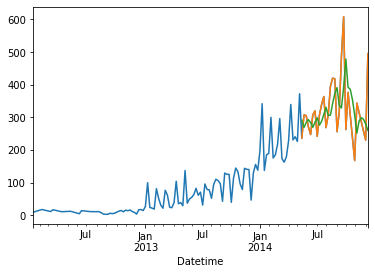

In [ ]:
ts.Count.plot()
val_subset.Count.plot()
val_subset.ses_model.plot()

# double expon smoothing model

In [ ]:
des_model = Holt(ts['Count']).fit(smoothing_level=0.1, smoothing_slope=0.2,optimized=True)
val_subset['des_model'] = des_model.predict(start=val_start,end=val_end)
des_rmse = np.sqrt(MSE(val_subset['Count'],val_subset['des_model']))
des_rmse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


96.74765521992066

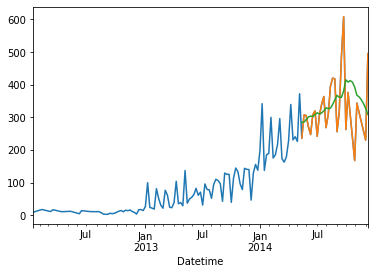

In [ ]:
ts.Count.plot()
val_subset.Count.plot()
val_subset.des_model.plot()

# triple expon smoothing or holts winters

In [ ]:
tes_model = ExponentialSmoothing(ts['Count'],trend='add',seasonal_periods=4,seasonal='mul').fit()
val_subset['tes_model'] = tes_model.predict(start=val_start,end=val_end)
tes_rmse = np.sqrt(MSE(val_subset['Count'],val_subset['tes_model']))
tes_rmse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


79.06450220473951

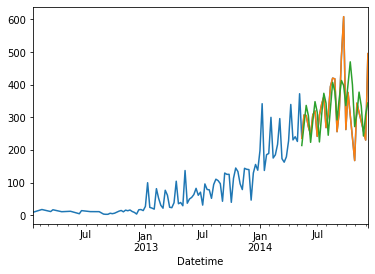

In [ ]:
ts.Count.plot()
val_subset.Count.plot()
val_subset.tes_model.plot()

# ARIMA model

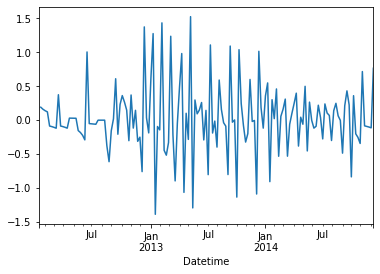

In [ ]:
#attemp to make the data stationary
ts['diff1'] = ts.Count.diff(1)
ts['log'] = np.log1p(ts.Count)
ts['log_diff1'] = ts.log.diff(1)
ts.log_diff1.plot()

In [ ]:
adfuller(ts.log_diff1[1:])
#the data is stationary

(-5.2419636852335865,
 7.2136451551334495e-06,
 9,
 142,
 {'1%': -3.477261624048995,
  '10%': -2.5777431104939494,
  '5%': -2.8821181874544233},
 131.9782822485465)

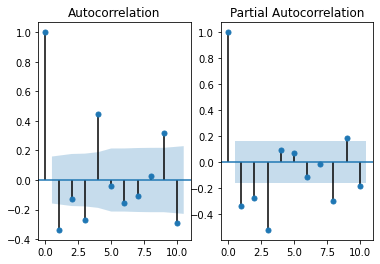

In [ ]:
fig,(ax,ax2) = plt.subplots(1,2)
acf= plot_acf(ts['log_diff1'][1:],ax=ax,lags=10)
pacf= plot_pacf(ts['log_diff1'][1:],ax=ax2,lags=10)

## ARIMA components
- AR(p) = 3
- MA(q) = 1
- i(lag) =1

In [ ]:
arima_model = ARIMA(ts['Count'],order=(3,1,1)).fit()
val_subset['arima_model'] = arima_model.predict(start=val_start,end=val_end)
arima_rmse = np.sqrt(MSE(val_subset['Count'],val_subset['arima_model']))
print(f"arima rmse: {arima_rmse}")
arima_model.summary()

arima rmse: 337.4454470435455


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Count   No. Observations:                  152
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -810.910
Method:                       css-mle   S.D. of innovations             49.967
Date:                Thu, 29 Apr 2021   AIC                           1633.820
Time:                        08:53:59   BIC                           1651.963
Sample:                    01-22-2012   HQIC                          1641.190
                         - 12-14-2014                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.1869      1.379      1.586      0.115      -0.516       4.890
ar.L1.D.Count    -0.5950      0.158     -3.764      0.000      -0.905      -0.285
ar.L2.D.Count    -0.5623      0.104     -5.413      0.000      -0.766      -0.359
ar.L3.D.Count    -0.5108      0.092     -5.568      0.000      -0.691      -0.331
ma.L1.D.Count    -0.1005      0.191     -0.527      0.599      -0.474       0.273
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.1150           -1.2074j            1.2129           -0.2349
AR.2            0.1150           +1.2074j            1.2129            0.2349
AR.3           -1.3308           -0.0000j            1.3308           -0.5000
MA.1            9.9471           +0.0000j            9.9471            0.0000
-----------------------------------------------------------------------------
"""

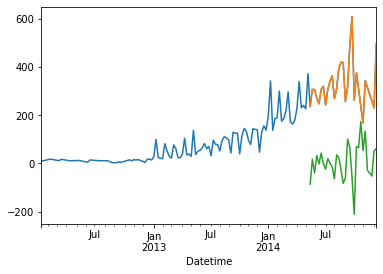

In [ ]:
ts.Count.plot()
val_subset.Count.plot()
val_subset.arima_model.plot()

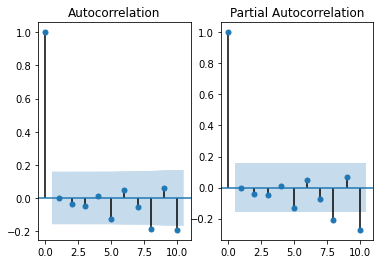

In [ ]:
#addressing the the trend problem with sarima
fig,(ax,ax2) = plt.subplots(1,2)
acf= plot_acf(arima_model.resid,ax=ax,lags=10)
pacf= plot_pacf(arima_model.resid,ax=ax2,lags=10)

In [ ]:
sarima_model = SARIMAX(ts['Count'],order=(3,1,1),seasonal_order=(0,1,1,4),trend='c').fit()
val_subset['sarima_model'] = sarima_model.predict(start=val_start,end=val_end)
sarima_rmse = np.sqrt(MSE(val_subset['Count'],val_subset['sarima_model']))
print("sarima rmse: ", sarima_rmse)

sarima rmse:  87.67969017877813


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


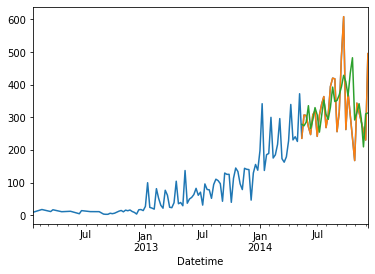

In [ ]:
ts.Count.plot()
val_subset.Count.plot()
val_subset.sarima_model.plot()

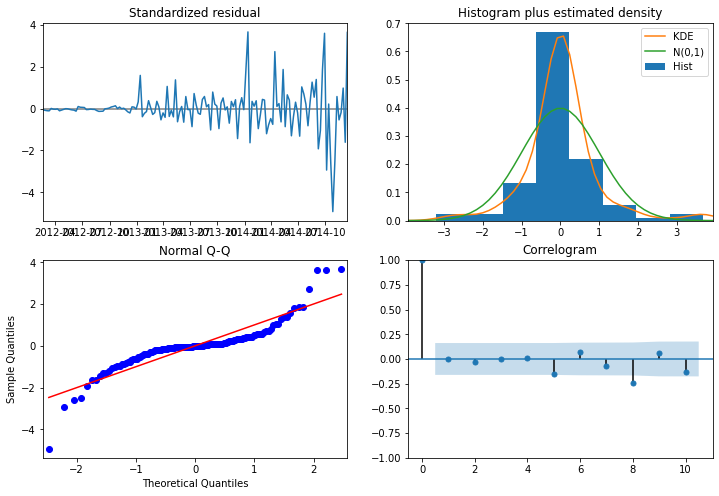

In [ ]:
sarima_diag = sarima_model.plot_diagnostics(figsize=(12,8))

In [ ]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             Count   No. Observations:                  153
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 4)   Log Likelihood                -792.098
Date:                           Thu, 29 Apr 2021   AIC                           1598.196
Time:                                   11:52:38   BIC                           1619.177
Sample:                               01-15-2012   HQIC                          1606.720
                                    - 12-14-2014                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1990      0.315      0.632      0.527      -0.418       0.816
ar.L1         -0.4116      0.185     -2.228      0.026      -0.774      -0.049
ar.L2         -0.3414      0.137     -2.488      0.013      -0.610      -0.072
ar.L3         -0.3946      0.082     -4.826      0.000      -0.555      -0.234
ma.L1         -0.3079      0.187     -1.650      0.099      -0.674       0.058
ma.S.L4       -0.9192      0.080    -11.486      0.000      -1.076      -0.762
sigma2      2482.7895    160.652     15.454      0.000    2167.918    2797.661
===================================================================================
Ljung-Box (Q):                       56.82   Jarque-Bera (JB):               276.87
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):              41.68   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
df_test['Datetime'] = pd.to_datetime(df_test['Datetime'])
df_test = df_test.set_index('Datetime')
#df_test.reset_index(inplace=True)
df_test.head()

,ID
Datetime,
2014-09-26 00:00:00,18288
2014-09-26 01:00:00,18289
2014-09-26 02:00:00,18290
2014-09-26 03:00:00,18291
2014-09-26 04:00:00,18292


In [ ]:
ts.tail()

,Count,log1p_Count,lag1_Count,diff1,log,log_diff1
Datetime,,,,,,
2014-11-16,315.220238,5.756439,343.523810,-28.303571,5.756439,-0.085724
2014-11-23,286.916667,5.662671,315.220238,-28.303571,5.662671,-0.093768
2014-11-30,258.613095,5.559192,286.916667,-28.303571,5.559192,-0.103479
2014-12-07,230.309524,5.443757,258.613095,-28.303571,5.443757,-0.115436
2014-12-14,495.250000,6.207080,230.309524,264.940476,6.207080,0.763323


In [ ]:
test_start = "2014-09-26"
test_end = "2015-04-26"
forecast_dataset = [pd.to_datetime("2014-09-26") + pd.DateOffset(weeks=x) for x in range(28)]
#forecast_dataset

In [ ]:
#2012-08-25 start
#2014-09-25 end

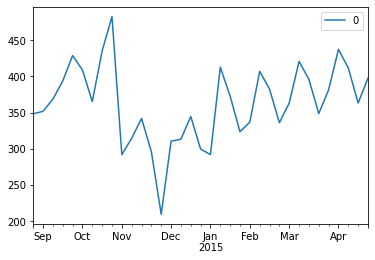

In [ ]:
future_forecast = sarima_model.predict(start="2014-08-31",end="2015-04-26")
future_forecast = future_forecast.to_frame()
future_forecast.plot()

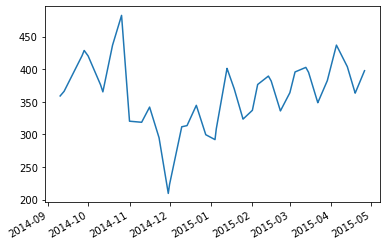

In [ ]:
future_forecast = future_forecast.resample("H",closed='left', label='left').mean().interpolate()
tes =pd.concat([df_test,future_forecast],axis=1,join='inner')
tes.rename(columns={'ID':'ID',0:'Count'},inplace=True)
tes['Count'].plot()

In [ ]:
tes.drop(['level_0','Datetime'],axis=1, inplace=True)

In [ ]:
tes = tes.reset_index()
tes.rename(columns={'index':'Datetime'},inplace=True)
tes.to_csv("7 month traffic forecasting.csv",index=False,index_label=False)

# Conclusion
1. model used: SARIMA
- with RMSE : 87.67
- AIC : 1598.196
- p=3 d=1 q=1 , P=0 D=1 Q=1 s=4

In [ ]:
sample_df = pd.read_csv("/content/sample_submission_LSeus50.csv")
sample_df.head()

,ID,Count
0,18288,0
1,18289,0
2,18290,0
3,18291,0
4,18292,0


In [ ]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5112 entries, 0 to 5111
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      5112 non-null   int64
 1   Count   5112 non-null   int64
dtypes: int64(2)
memory usage: 80.0 KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5112 entries, 2014-09-26 00:00:00 to 2015-04-26 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      5112 non-null   int64
dtypes: int64(1)
memory usage: 239.9 KB
